## Introduction to Physics-Informed Neural Networks (PINNs)

In this section, we introduce the motivation behind *Physics-Informed Neural Networks* (PINNs) and present a simple application.

PINNs have emerged as a powerful class of neural networks designed to solve *partial differential equations* (PDEs) that govern physical systems. Their key advantage lies in their ability to **amplify the information content of limited data by incorporating structured prior knowledge** about the underlying physical laws.

These physical principles — whether they are fundamental laws of motion, conservation principles, or empirically validated rules — often encode symmetries, invariances, and other constraints that any admissible solution must satisfy. By enforcing these constraints directly within the learning process, PINNs effectively restrict the space of possible solutions, making it easier to draw meaningful conclusions and make reliable predictions, even in small-data regimes.

In this work, we follow the seminal work of [Raissi et al.](https://arxiv.org/abs/1711.10561). We directly tackle nonlinear PDE problems without resorting to linearization, prior assumptions, or local time-stepping schemes.

We start by implementing a **continuous-time inference algorithm**, which aims to find the solution of the PDE given fixed parameters — this corresponds to the *data-driven solution* problem.

Unlike the original implementations that primarily used TensorFlow, we develop our example using **PyTorch**, illustrating how to construct and train a PINN model from scratch in a modern and flexible deep learning framework.


## The 1-Dimensional Burgers' Equation

The Burgers' equation is a fundamental nonlinear partial differential equation that models several physical phenomena such as fluid dynamics, gas dynamics, and traffic flow. Given its versatility yet simplicity, we chose it as a first example for our work — serving as a benchmark problem for testing numerical solvers and data-driven approaches such as Physics-Informed Neural Networks (PINNs).

The one-dimensional Burgers' equation is given by:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, 
\quad x \in [-1, 1], \ t \in [0, 1],
$$
where $u = u(x, t)$ represents the velocity field and $ \nu $ is the viscosity coefficient.  
We impose the initial condition:

$$
u(0, x) = \sin(\pi x),
$$

and Dirichlet boundary conditions:

$$
u(t, -1) = 0, \quad u(t, 1) = 0.
$$

Since the aim is to find data-driven solutions, we fix the viscosity coefficient to be: 
$$ \nu = \frac{0.01}{\pi}$$

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)

We establish the simulation domain for the Burgers’ equation by defining spatial and temporal boundaries, viscosity, and the number of collocation, initial, and boundary points. It then generates random and evenly spaced data points for these conditions and converts them into PyTorch tensors, enabling gradient computation where needed.

In [ ]:
# spatial and temporal domain boundaries
x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0

#viscosity coefficient
nu = 0.01 / np.pi

# collocation points
N_f = 10000
N_0 = 200
N_b = 200

# Initial and boundary conditions
X_f = np.random.rand(N_f, 2)
X_f[:, 0] = X_f[:, 0] * (x_max - x_min) + x_min  # x in [-1, 1]
X_f[:, 1] = X_f[:, 1] * (t_max - t_min) + t_min    # t in [0, 1]

# Initial condition on velocity: u(x, 0) = -sin(pi * x)
x0 = np.linspace(x_min, x_max, N_0)[:, None]
t0 = np.zeros_like(x0)
u0 = -np.sin(np.pi * x0)

# Boundary conditions: u(-1, t) = 0, u(1, t) = 0
tb = np.linspace(t_min, t_max, N_b)[:, None]
xb_left = np.ones_like(tb) * x_min
xb_right = np.ones_like(tb) * x_max
ub_left = np.zeros_like(tb)
ub_right = np.zeros_like(tb)

# Convert to PyTorch tensors
X_f = torch.tensor(X_f, dtype=torch.float32, requires_grad=True) # enable gradients for collocation points
x0 = torch.tensor(x0, dtype=torch.float32)
t0 = torch.tensor(t0, dtype=torch.float32)
u0 = torch.tensor(u0, dtype=torch.float32)
tb = torch.tensor(tb, dtype=torch.float32)
xb_left = torch.tensor(xb_left, dtype=torch.float32)
xb_right = torch.tensor(xb_right, dtype=torch.float32)
ub_left = torch.tensor(ub_left, dtype=torch.float32)
ub_right = torch.tensor(ub_right, dtype=torch.float32)

## PINN model

We implement a very simple physics-informed neural network. The network dynamics depend on its depth and number of neurons. We use `tanh` as activation, which naturally scales outputs to [-1, 1].

Then, we built a model with 4 hidden layers, each consisting of 50 hidden units.


In [ ]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh() # naturally scales network output to [-1, 1]

        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        return self.layers[-1](x)

layers = [2, 50, 50, 50, 50, 1]
model = PINN(layers)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PINN(
  (activation): Tanh()
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)


## PDE Residual and Loss Function

The function `pde_residual` computes the physics-based residual of the PDE. It calculates the required derivatives of the network output $u(x,t)$ with respect to space and time using automatic differentiation, and evaluates the Burgers’ equation residual $u_t + u u_x - \nu u_{xx}$.  

The `loss_func` combines three components: the PDE residual loss, the initial condition loss, and the boundary condition loss.
By construction, it ensures that the network respects both the physics and the prescribed initial/boundary conditions.


In [ ]:
def pde_residual(model, X):
    x = X[:, 0:1] 
    t = X[:, 1:2] 
    u = model(torch.cat([x, t], dim=1)) # network output u(x,t)

    u_x = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_t = autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]

    f = u_t + u * u_x - nu * u_xx  # Burgers' equation residual
    return f

def loss_func(model):

    # PDE residual loss
    f_pred = pde_residual(model, X_f.to(device))
    loss_f = torch.mean(f_pred**2)

    # Initial condition loss
    u0_pred = model(torch.cat([x0.to(device), t0.to(device)], dim=1))
    loss_0 = torch.mean((u0_pred - u0.to(device))**2)

    # Boundary condition loss
    u_left_pred = model(torch.cat([xb_left.to(device), tb.to(device)], dim=1))
    u_right_pred = model(torch.cat([xb_right.to(device), tb.to(device)], dim=1))
    loss_b = torch.mean(u_left_pred**2) + torch.mean(u_right_pred**2)

    loss = loss_f + loss_0 + loss_b
    return loss

## Training

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_func(model)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.5e}')

print("Training complete!")

c:\Users\valev\AppData\Local\Programs\Python\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 500/5000, Loss: 1.07389e-01
Epoch 1000/5000, Loss: 9.18695e-02
Epoch 1500/5000, Loss: 8.35586e-02
Epoch 2000/5000, Loss: 4.10609e-02
Epoch 2500/5000, Loss: 2.45724e-02
Epoch 3000/5000, Loss: 1.60427e-02
Epoch 3500/5000, Loss: 1.32157e-02
Epoch 4000/5000, Loss: 7.35813e-03
Epoch 4500/5000, Loss: 5.24374e-03
Epoch 5000/5000, Loss: 4.13675e-03
Training complete!


## Visualizing the PINN Solution

We define a grid in space and time using `N_x` and `N_t` points, and evaluate the trained PINN model on this grid. The predictions are reshaped to match the grid dimensions and plotted using a contour plot, showing the predicted solution $u(x,t)$ over the space-time domain.

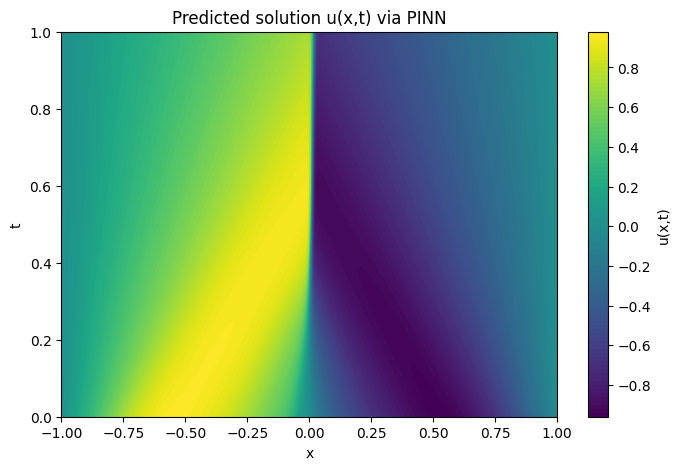

In [13]:
N_x, N_t = 256, 100
x = np.linspace(x_min, x_max, N_x)
t = np.linspace(t_min, t_max, N_t)
X, T = np.meshgrid(x, t)
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(XT_tensor).cpu().numpy().reshape(N_t, N_x)

plt.figure(figsize=(8, 5))
plt.contourf(X, T, u_pred, levels=100, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title("Predicted solution u(x,t) via PINN")
plt.show()

The PINN model we implemented is very simple and purely physics-driven. It does not use any real solution points; instead, it relies entirely on the Burgers’ PDE and collocation points sampled in the spatio-temporal domain. Boundary and initial conditions are enforced in the loss function, so the network learns a solution that satisfies the physics, but it has no access to actual measurements. This approach is elegant and minimal, but its accuracy may be limited near sharp gradients or shocks where the PDE solution changes rapidly.

We now consider a second model, which blends physics constraints with real data. This hybrid PINN loads solution data from `burgers_shock.mat` provided in Raissi's GitHub repository. From this dataset, we construct `X_u_train` and `u_train` using measurements at the initial and boundary points, and then randomly sample `N_u` points from these to train the network. At the same time, the PDE residual is still enforced at collocation points (`X_f_train`) to maintain physics consistency. By combining supervised data with physics-informed training, this hybrid model can achieve higher accuracy, particularly in regions with steep gradients or shocks.

## Hybrid PINN model - Physics and data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import matplotlib.pyplot as plt
import time

np.random.seed(1234)
torch.manual_seed(1234)

class PhysicsInformedNN:
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, device='cpu'):
        self.lb = torch.tensor(lb, dtype=torch.float32, device=device)
        self.ub = torch.tensor(ub, dtype=torch.float32, device=device)
        self.nu = nu
        self.device = device

        self.x_u = torch.tensor(X_u[:, 0:1], dtype=torch.float32, device=device)
        self.t_u = torch.tensor(X_u[:, 1:2], dtype=torch.float32, device=device)
        self.u = torch.tensor(u, dtype=torch.float32, device=device)

        self.x_f = torch.tensor(X_f[:, 0:1], dtype=torch.float32, device=device)
        self.t_f = torch.tensor(X_f[:, 1:2], dtype=torch.float32, device=device)

        self.layers = layers
        self.model = self.build_model(layers).to(device)

    def build_model(self, layers):
        modules = []
        for i in range(len(layers) - 2):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))
        return nn.Sequential(*modules)

    def net_u(self, x, t):
        X = torch.cat([x, t], dim=1)
        X_scaled = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        return self.model(X_scaled)

    def net_f(self, x, t):
        x.requires_grad = True
        t.requires_grad = True
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        f = u_t + u * u_x - self.nu * u_xx
        return f

    def loss_func(self):
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred)**2)
        loss_f = torch.mean(f_pred**2)
        return loss_u + loss_f

    def train(self, epochs=5000, lr=1e-3):
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = self.loss_func()
            loss.backward()
            optimizer.step()
            if epoch % 500 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item():.5e}')

    def predict(self, X_star):
        x_star = torch.tensor(X_star[:, 0:1], dtype=torch.float32, device=self.device)
        t_star = torch.tensor(X_star[:, 1:2], dtype=torch.float32, device=self.device)
        u_star = self.net_u(x_star, t_star).detach().cpu().numpy()
        f_star = self.net_f(x_star, t_star).detach().cpu().numpy()
        return u_star, f_star


nu = 0.01/np.pi
N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('../Data/burgers_shock.mat')
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

lb = X_star.min(0)
ub = X_star.max(0)

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub - lb) * lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx, :]

model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

start_time = time.time()
model.train()
elapsed = time.time() - start_time
print('Training time: %.4f' % elapsed)

u_pred, f_pred = model.predict(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print('Error u: %e' % error_u)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')